In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from skimage.io import imread
from PIL import Image

#import image_processing as img_pr

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_theme(style="darkgrid")

plt.rcParams['figure.figsize'] = [15, 8]
plt.rc('font', size=14)          # controls default text sizes
plt.rc('figure', titlesize=15)  # fontsize of the figure title

c:\Users\valer\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
def savefig(name, add_pdf=True):
    path = f"отчет/pictures/{name}"
    if add_pdf:
        path = path + ".pdf"
    plt.savefig(path, bbox_inches='tight')

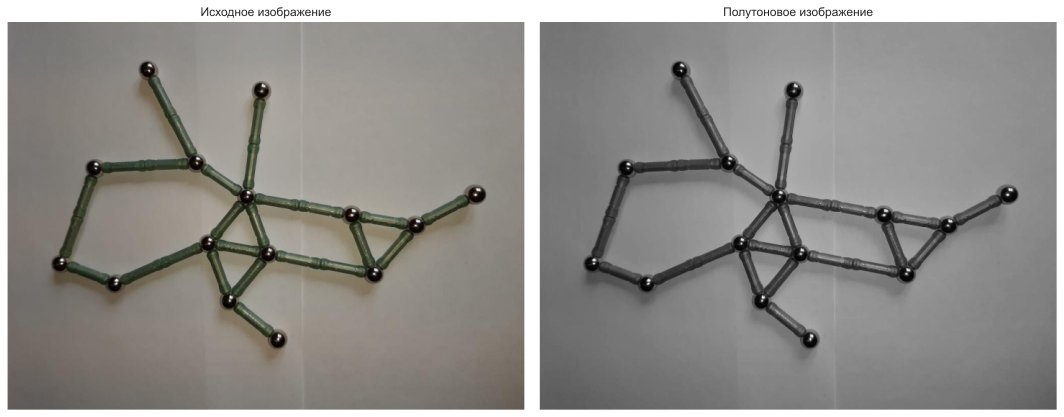

In [3]:
imgs_path = "Обучение"
img_path = os.path.join(imgs_path, "4.jpg")

img = imread(img_path)

gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Исходное изображение")

plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap="gray")
plt.axis("off")
plt.title("Полутоновое изображение")

plt.tight_layout()
plt.show()

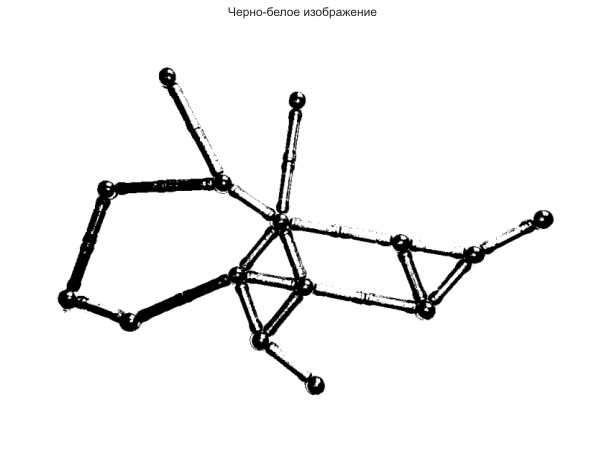

In [4]:
thresh = 75
black_white_img = cv.threshold(gray_img, thresh, 255, cv.THRESH_BINARY)[1]
plt.imshow(black_white_img, cmap="gray")
plt.axis("off")
plt.title("Черно-белое изображение")
plt.show()

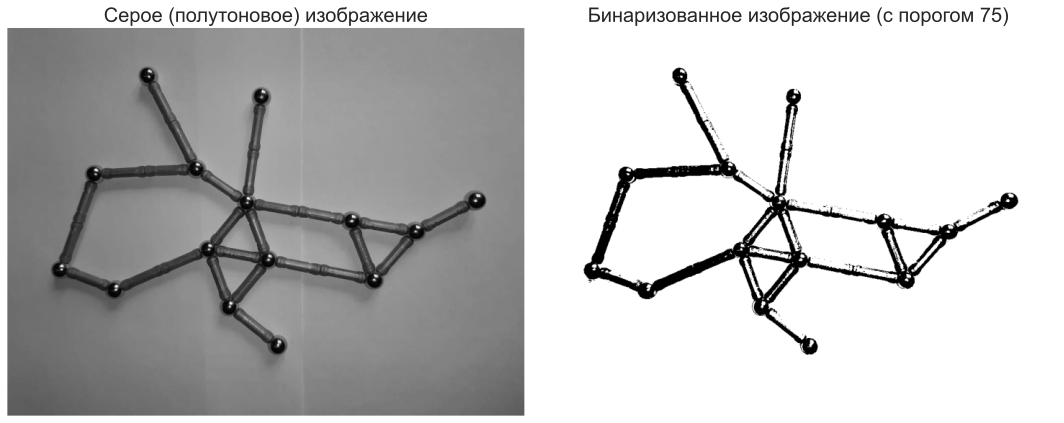

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap="gray")
plt.axis("off")
plt.title("Серое (полутоновое) изображение", fontdict={'fontsize' : 20})

plt.subplot(1, 2, 2)
plt.imshow(black_white_img, cmap="gray")
plt.axis("off")
plt.title(f"Бинаризованное изображение (с порогом {thresh})", fontdict={'fontsize' : 20})

plt.tight_layout()

savefig("gray_and_black_white_img")

plt.show()

In [6]:
MAX_BRIGHTNESS = 255

def make_morph_ex(black_and_white_img, ex, kernel_shape, object_is_black=True):
    if object_is_black:
        black_and_white_img = MAX_BRIGHTNESS - black_and_white_img

    try:
        iter(kernel_shape)
        kernel = np.ones(kernel_shape, np.uint8)
    except TypeError:
        kernel = np.ones((kernel_shape, kernel_shape), np.uint8)

    if ex == "erosion":
        res = cv.erode(black_and_white_img, kernel, iterations=1)
    elif ex == "dilation":
        res = cv.dilate(black_and_white_img, kernel, iterations=1)
    elif ex == "opening":
        res = cv.morphologyEx(black_and_white_img, cv.MORPH_OPEN, kernel)
    elif ex == "closing":
        res = cv.morphologyEx(black_and_white_img, cv.MORPH_CLOSE, kernel)
    else:
        raise NotImplementedError("unknown morph ex")
    
    if object_is_black:
        res = MAX_BRIGHTNESS - res

    return res

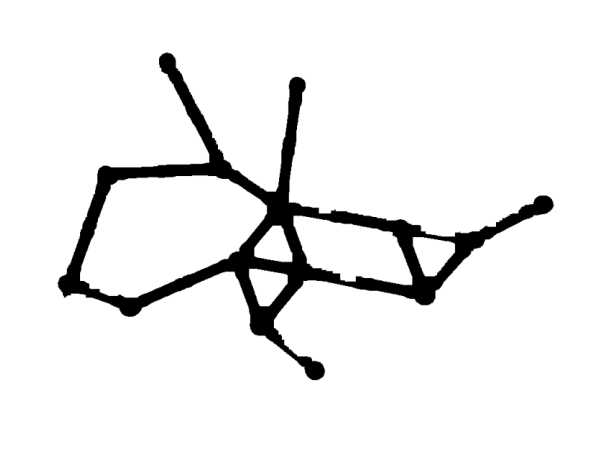

In [7]:
black_white_img_ = black_white_img.copy()
black_white_img_ = make_morph_ex(black_white_img_, "closing", (15, 15))
#black_white_img_ = make_morph_ex(black_white_img_, "dilation", (20, 20))
#black_white_img_ = make_morph_ex(black_white_img_, "opening", (2, 2))


plt.imshow(black_white_img_, cmap="gray")
plt.axis("off")
#plt.title("Черно-белое изображение после морфологических операций", fontdict={'fontsize' : 15})
savefig("after_closing")
plt.show()

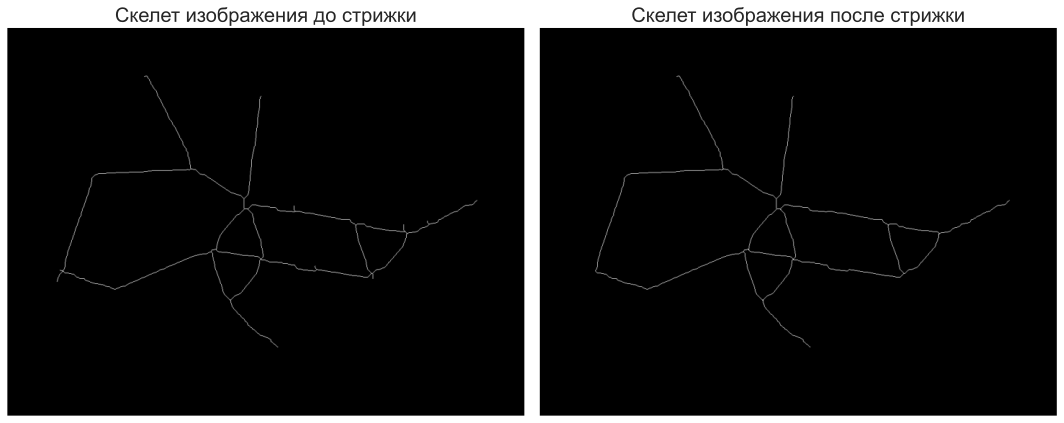

In [8]:
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt
from dsepruning import skel_pruning_DSE


skel_ = skeletonize(MAX_BRIGHTNESS - black_white_img_)
dist = distance_transform_edt(MAX_BRIGHTNESS - black_white_img_, return_indices=False, return_distances=True)
skel, graph = skel_pruning_DSE(skel_, dist, min_area_px=600, return_graph=True)

plt.subplot(1, 2, 1)
plt.imshow(skel_, cmap="gray")
plt.axis("off")
plt.title("Скелет изображения до стрижки", fontdict={'fontsize' : 20})

plt.subplot(1, 2, 2)
plt.imshow(skel, cmap="gray")
plt.axis("off")
plt.title("Скелет изображения после стрижки", fontdict={'fontsize' : 20})

plt.tight_layout()
savefig("skel")
plt.show()

In [14]:
def skeleton_image_to_graph(skeIm, connectivity=8):
    """
    https://stackoverflow.com/questions/41008973/how-to-extract-skimage-skeleton-information-to-networkx-nodes-and-edges-in-pytho
    """
    assert(len(skeIm.shape) == 2)
    skeImPos = np.stack(np.where(skeIm))
    skeImPosIm = np.zeros_like(skeIm, dtype="int")
    skeImPosIm[skeImPos[0], skeImPos[1]] = np.arange(0, skeImPos.shape[1])
    g = nx.Graph()
    if connectivity == 4:
        neigh = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    elif connectivity == 8:
        neigh = np.array([[0, 1], [0, -1], [1, 0], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]])
    else:
        raise ValueError(f'unsupported connectivity {connectivity}')
    for idx in range(skeImPos[0].shape[0]):
        for neighIdx in range(neigh.shape[0]):
            curNeighPos = skeImPos[:, idx] + neigh[neighIdx]
            if np.any(curNeighPos<0) or np.any(curNeighPos>=skeIm.shape):
                continue
            if skeIm[curNeighPos[0], curNeighPos[1]] > 0:
                g.add_edge(skeImPosIm[skeImPos[0, idx], skeImPos[1, idx]], skeImPosIm[curNeighPos[0], curNeighPos[1]], weight=np.linalg.norm(neigh[neighIdx]))
    g.graph['physicalPos'] = skeImPos.T
    return g

In [284]:
#graph = skeleton_image_to_graph(skel)
degrees = sorted([d for n, d in graph.degree()])

unique_degrees, counts_degrees = np.unique(degrees, return_counts=True)
np.column_stack((unique_degrees, counts_degrees))

array([[1, 3],
       [2, 1],
       [3, 9]], dtype=int64)

In [9]:
class EquivalenceNodes:
    def __init__(self, nodes=None, thresh=25):
        self.thresh = thresh
        self.nodes = []
        self.centers_sum = np.array([0, 0])
        self.degrees_sum = 0
        if nodes is not None:
            for node in nodes:
                self.add(node)

    def get_mean_center(self):
        if len(self.nodes) == 0:
            return None
        return self.centers_sum / len(self.nodes)
    
    mean_center = property(get_mean_center)

    @staticmethod
    def _squared_dist(p0, p1):
        return (p0[0] - p1[0]) ** 2 + (p0[1] - p1[1]) ** 2
    
    def __contains__(self, node):
        return self._squared_dist(node["pts"][0], self.mean_center) < self.thresh ** 2

    def add(self, node):
        self.nodes.append(node)
        self.centers_sum += node["pts"][0]
        self.degrees_sum += node["degree"]

    def get_generalized_node(self):
        node = {
            "pts": np.array([self.mean_center], dtype=np.int16),
            "o": np.array(self.mean_center, dtype=np.uint16),
            "degree": self.degrees_sum - 2 * (len(self.nodes) - 1)
        }
        return node
    
    generalized_node = property(get_generalized_node)


def get_unique_nodes(graph, thresh=25):
    nodes_with_degrees = [(n, d) for n, d in graph.degree()]
    nodes = graph.nodes()

    equivalence_classes = []
    for node, degree in nodes_with_degrees:
        node = nodes[node].copy()
        node["degree"] = degree
        exists = False
        for equivalence_class in equivalence_classes:
            if node in equivalence_class:
                exists = True
                equivalence_class.add(node)
                break
        if not exists:
            equivalence_classes.append(EquivalenceNodes([node], thresh=thresh))

    unique_nodes = []
    for equivalence_class in equivalence_classes:
        unique_nodes.append(equivalence_class.generalized_node)

    return unique_nodes

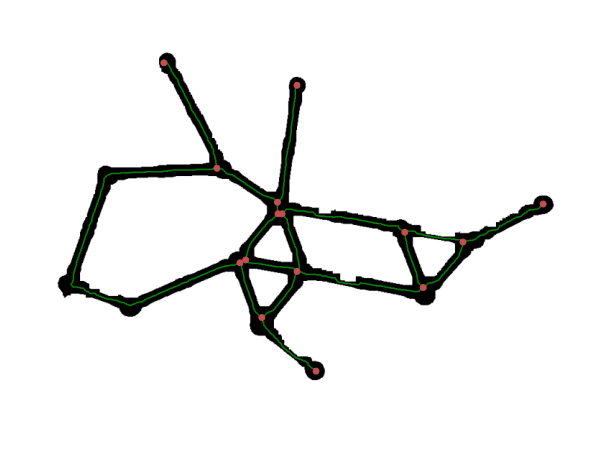

In [10]:
black_white_img__ =  black_white_img_.copy()
black_white_img__ = cv.cvtColor(black_white_img__, cv.COLOR_GRAY2RGB)

# draw image
plt.imshow(black_white_img__, cmap='gray')

# draw edges by pts
for (s,e) in graph.edges():
    for elem in graph[s][e].values():
        ps = elem['pts']
        plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'ro')

# title and show
#plt.title('Build Graph')
plt.axis("off")

savefig("skel_nodes")
plt.show()

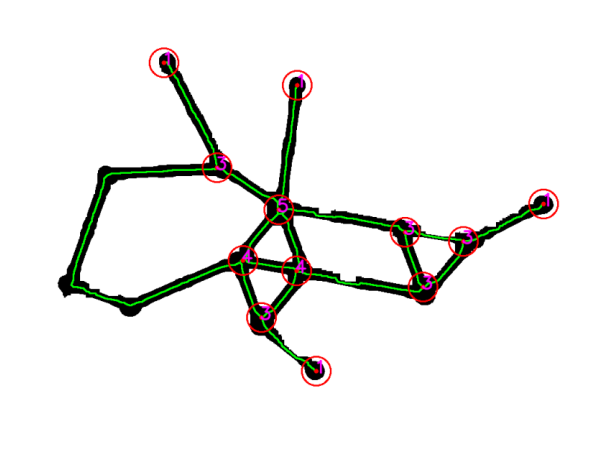

In [11]:
black_white_img__ =  black_white_img_.copy()
black_white_img__ = cv.cvtColor(black_white_img__, cv.COLOR_GRAY2RGB)

# draw edges by pts
for (s,e) in graph.edges():
    for elem in graph[s][e].values():
        ps = elem['pts']
        pts = ps[:, ::-1].reshape((-1, 1, 2)).astype(np.int32)
        cv.polylines(black_white_img__, [pts], False, (0, 255, 0), 2)

    
# draw node by o
nodes = get_unique_nodes(graph, thresh=25)
for node in nodes:
    center = node["o"][::-1]
    radius=25
    # circle center
    cv.circle(black_white_img__, center, 1, (255, 0, 0), 5)
    # circle outline
    cv.circle(black_white_img__, center, radius, (255, 0, 0), 2)

    cv.putText(black_white_img__, str(node["degree"]), org=center + np.array([-3, 3]), fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=1,
                color=(255, 0, 255), thickness=2, lineType=cv.LINE_AA)

# draw image
plt.imshow(black_white_img__)

# title and show
#plt.title('Build Graph')
plt.axis("off")

savefig("skel_nodes_after_union")
plt.show()

In [19]:
def get_degree_vector(img_path, bin_thresh=75, closing_kernel_shape=(15, 15), dse_min_area_px=600, max_degree=6):
    img = imread(img_path)
    gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    black_white_img = cv.threshold(gray_img, bin_thresh, 255, cv.THRESH_BINARY)[1]
    black_white_img = make_morph_ex(black_white_img, "closing", closing_kernel_shape)
    
    skel = skeletonize(MAX_BRIGHTNESS - black_white_img)
    dist = distance_transform_edt(MAX_BRIGHTNESS - black_white_img, return_indices=False, return_distances=True)
    skel, graph = skel_pruning_DSE(skel, dist, min_area_px=dse_min_area_px, return_graph=True)
    nodes = get_unique_nodes(graph)
    degrees = sorted([node["degree"] for node in nodes])

    unique_degrees, counts_degrees = np.unique(degrees, return_counts=True)

    degree_vector = np.zeros(np.max(unique_degrees), dtype="int")

    for degree, count in zip(unique_degrees, counts_degrees):
        if degree > max_degree:
            break
        degree_vector[degree - 1] = count

    return degree_vector

In [13]:
img_class_1 = ["2.jpg", "13.jpg"]
img_class_2 = ["3.jpg", "25.jpg"]
img_class_3 = ["4.jpg", "19.jpg"]
img_class_4 = ["5.jpg", "7.jpg"]

degrees_vectors = []

In [14]:
# class 1
for img_path in img_class_1:
    degree_vector = get_degree_vector(os.path.join(imgs_path, img_path))
    degrees_vectors.append(degree_vector)
    print(degree_vector)

[3 1 3 3]
[3 1 3 3]


In [15]:
# class 2
for img_path in img_class_2:
    degree_vector = get_degree_vector(os.path.join(imgs_path, img_path))
    degrees_vectors.append(degree_vector)
    print(degree_vector)

[4 0 4 1]
[4 0 4 1]


In [16]:
# class 3
for img_path in img_class_3:
    degree_vector = get_degree_vector(os.path.join(imgs_path, img_path))
    degrees_vectors.append(degree_vector)
    print(degree_vector)

[4 0 5 2 1]
[4 0 5 2 1]


In [17]:
# class 4
for img_path in img_class_4:
    degree_vector = get_degree_vector(os.path.join(imgs_path, img_path))
    degrees_vectors.append(degree_vector)
    print(degree_vector)

[6 0 4 2]
[6 0 4 2]


In [20]:
def _dist(vec1, vec2):
    l1 = vec1.shape[0]
    l2 = vec2.shape[0]
    if l1 < l2:
        vec1 = np.concatenate([vec1, np.zeros(l2 - l1, dtype="int")])
    elif l1 > l2:
        vec2 = np.concatenate([vec2, np.zeros(l1 - l2, dtype="int")])
    return np.sum((vec1 - vec2) ** 2)

In [21]:
assert len(degrees_vectors) == len(img_class_1) + len(img_class_2) + len(img_class_3) + len(img_class_4)

dists = np.zeros((len(degrees_vectors), len(degrees_vectors)), dtype="int")

for i, vec1 in enumerate(degrees_vectors):
    for j, vec2 in enumerate(degrees_vectors):
        dists[i, j] = _dist(vec1, vec2)

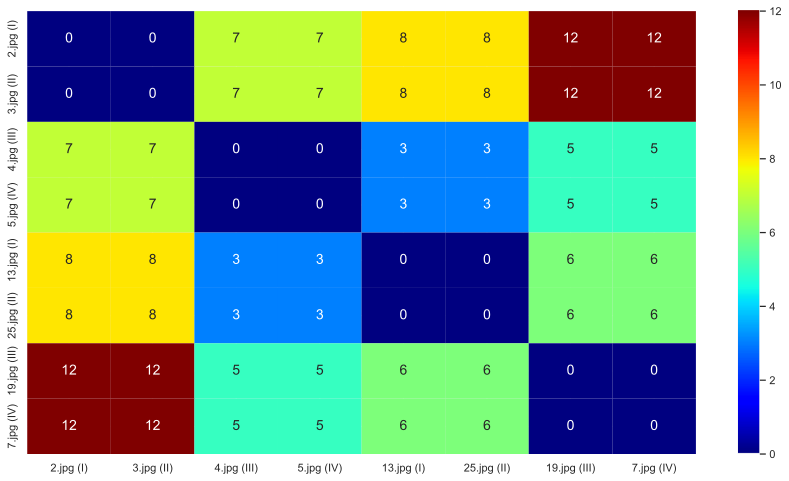

In [24]:
pictures = ["2.jpg", "3.jpg", "4.jpg", "5.jpg",
            "13.jpg", "25.jpg", "19.jpg", "7.jpg"]
classes = ["I", "II", "III", "IV"] + ["I", "II", "III", "IV"]

labels = []
for pict, cls in zip(pictures, classes):
    labels.append(pict + f" ({cls})")

sns.heatmap(dists, annot=True, fmt="d", cmap="jet", xticklabels=labels, yticklabels=labels)

savefig("dists")
plt.show()

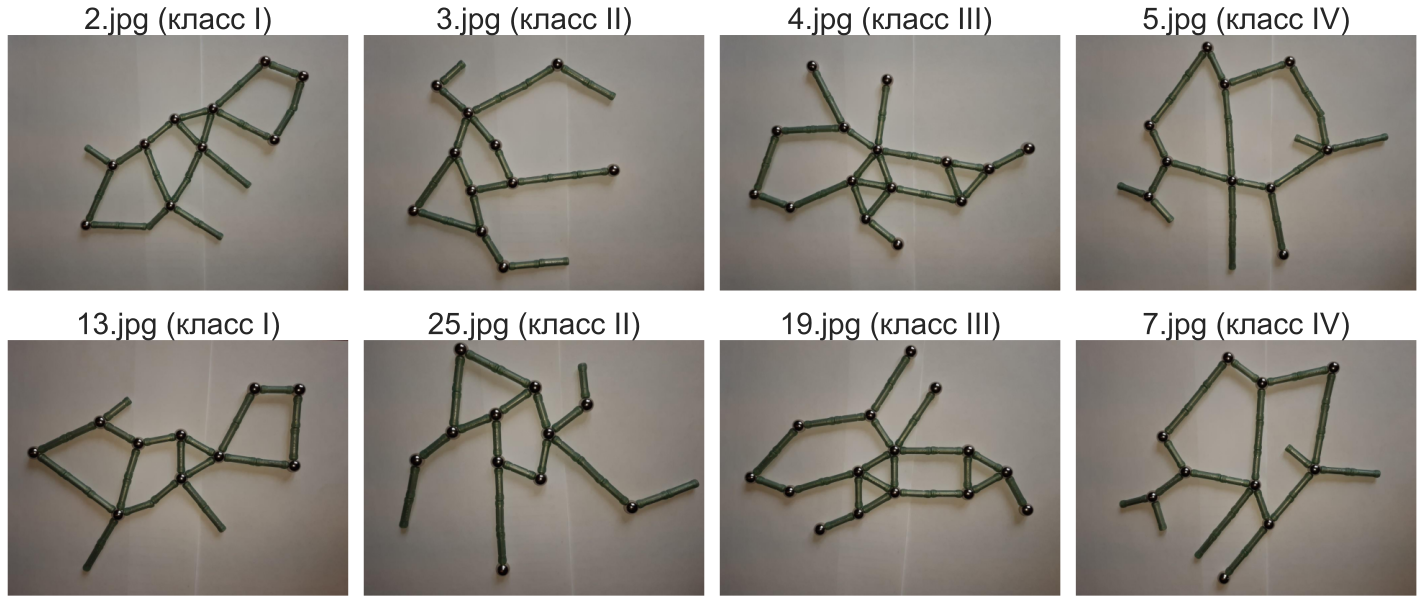

In [53]:
plt.figure(figsize=(20, 9))

for i, picture in enumerate(pictures):
    image = plt.imread(os.path.join(imgs_path, picture))
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(picture + f" (класс {classes[i]})", fontdict={'fontsize' : 30})
    plt.axis("off")

plt.tight_layout()
plt.savefig(f"отчет/pictures/all_inputs.pdf", bbox_inches='tight')
plt.show()